In [1]:
%pylab inline

import tensorflow as tf
import tensorflow_probability as tfp
import tensorflow_datasets as tfds
#  Important !!!! path to shared tensorflow dataset
data_dir='/storage/scratch/mhuertas/data/sfh/tensorflow_datasets/tng100/'

%pylab is deprecated, use %matplotlib inline and import the required libraries.
Populating the interactive namespace from numpy and matplotlib


In [24]:
from sfh.datasets.tng100 import tng100

In [26]:
dset = tfds.load('tng100', split='train', data_dir=data_dir)

In [4]:
# Reordering the wavelenghts
wl = np.loadtxt('/storage/scratch/mhuertas/data/sfh/tensorflow_datasets/tng100/downloads/manual/wl.csv')
inds = argsort(wl)

In [5]:
""""Keras model implementing PixelCNN."""

import tensorflow as tf
import tensorflow_probability as tfp
from tensorflow import keras
from tensorflow.keras import layers
import sys
import time
tfd = tfp.distributions
tfb = tfp.bijectors
tfkl=keras.layers

def generate_model(n_timesteps, *, n_channels=1, n_components=2, kernel_size=3,
                   n_dilations=5, list_of_dilation_rates=None,
                   list_of_filters=None):
    """Generate the PixelCNN Keras model.

    Parameters
    ----------
    n_timesteps : int
        Number of time steps.
    n_channels : int, default 1
        Number of channels in the dataset
    n_components : int, default 2
        Number of components in the Gaussian mixture distribution.
    kernel_size : int, default 3
        Size of the convolution kernel.
    n_dilations : int, default 5
        Number of dilated convolutions to do. For each convolution, the
        dilation rate is 2**idx+1 and the number of filters is 2**idx+4.
    list_of_dilation_rates : list of int or None, default None
        List of the dilation rates to use in the dilated convolutions. If not
        None, the n_dilations is not used and filters must be given with the
        same size.
    list_of_filters : list of int or None, default None
        List of the filter number for each of the dilated convolutions. Must be
        of the same size as list_of_dilation_rates

    Returns
    -------
    Keras model

    """
    # Shape of the distribution
    event_shape = [1]
    # Compute how many parameters this distribution requires
    params_size = 2
    #print(params_size)

    
    input_sfh = keras.layers.Input(shape=(100,1))
    input_sed = keras.layers.Input(shape=(143,1))
    
    # Compress the SED and return some channels
    sed_net = tf.keras.Sequential([
        tfkl.Input(shape=(143, 1)),
        tfkl.Conv1D(16, 3, strides=2, padding='same', activation='relu'),
        tfkl.Conv1D(32, 3, strides=2, padding='same', activation='relu'),
        tfkl.Conv1D(64, 3, strides=2, padding='same', activation='relu'),
        tfkl.Conv1D(64, 3, strides=1, padding='same', activation='relu'),
        tfkl.Flatten(),
        tfkl.Dense(128, activation='relu'),
        tfkl.Dense(8, activation='softplus'),
        tfkl.Lambda(lambda x: tf.tile(tf.reshape(x,[-1,1,8]), [1,100,1]))
        ])
    
    merged = keras.layers.Concatenate(axis=-1)([input_sfh, 
                                                sed_net(input_sed)])
    
    
    # Shift and cut
    net = keras.layers.Lambda(
            lambda x: tf.pad(x, paddings=tf.constant([[0, 0], [1, 0], [0, 0]]))
        )(merged)
    
    net=keras.layers.Lambda(
            lambda x: x[:, :-1, :]
        )(net)
    

    net=keras.layers.Conv1D(
            filters=16,
            kernel_size=kernel_size,
            dilation_rate=1,
            padding='causal',
            activation='relu'
        )(net)

    if list_of_dilation_rates is None:
        list_of_dilation_rates = [2**(i+1) for i in range(n_dilations)]
        list_of_filters = [2**(i+4) for i in range(n_dilations)]
    elif len(list_of_filters) != len(list_of_dilation_rates):
        raise ValueError(
            "filters and list_of_dilation_rates must have the same length")

    for dilation_rate, nb_filters in zip(list_of_dilation_rates,
                                         list_of_filters):
        net = keras.layers.Conv1D(
                filters=nb_filters,
                kernel_size=kernel_size,
                dilation_rate=dilation_rate,
                padding='causal',
                activation='relu')(net)
    
    net = keras.layers.Dense(2)(net)
    
    net = tfp.layers.DistributionLambda(
                    make_distribution_fn=lambda t: tfd.Beta(
                          concentration1=tf.math.softplus(t[..., 0])+1e-3,
                          concentration0=tf.math.softplus(t[..., 1])+1e-3)
                    )(net)
    
    pixel_cnn = keras.models.Model(inputs=[input_sfh, input_sed],
                                  outputs=net)

    # Use the negative log-likelihood as loss function.
    def negloglik(y, q):
        return tf.reduce_sum(-q.log_prob(y[...,0]), -1)
    
    opt = tf.keras.optimizers.Adam(learning_rate=0.0002)
    pixel_cnn.compile(loss=negloglik, optimizer=opt)

    return pixel_cnn

In [6]:
pixel_cnn = generate_model(100)

pixel_cnn.summary()

2022-04-08 13:22:52.845545: W tensorflow/python/util/util.cc:368] Sets are not currently considered sequences, but this may change in the future, so consider avoiding using them.


Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 143, 1)]     0           []                               
                                                                                                  
 input_1 (InputLayer)           [(None, 100, 1)]     0           []                               
                                                                                                  
 sequential (Sequential)        (None, 100, 8)       168808      ['input_2[0][0]']                
                                                                                                  
 concatenate (Concatenate)      (None, 100, 9)       0           ['input_1[0][0]',                
                                                                  'sequential[0][0]']         

In [10]:
def preprocessing(example):
    return tf.reshape(example['SFR_Max'],(-1,100,1)), \
           tf.reshape(example['SFR_Max'],(-1,100,1))

def preprocessing_wmass(example):
    mass = example['Mstar'][:,0]
    mass_half = example['Mstar_Half'][:,0]
    tiler = tf.constant([100])
    mass = tf.reshape(tf.tile(mass, tiler),(-1,100,1))
    mass_half = tf.reshape(tf.tile(mass_half, tiler),(-1,100,1))
    sfr = tf.math.add(tf.reshape(example['SFR_Max'],(-1,100,1)), 1e-5)
    res = tf.concat([sfr, mass, mass_half], axis=2)
    return res, res

def preprocessing_wmass_atan(example):
    mass = example['Mstar'][:,0]
    mass_half = example['Mstar_Half'][:,0]
    sed = (tf.gather(example['sed'],inds, axis=1) + 20.70243)/2.0466275
    tiler = tf.constant([100])
    mass = tf.reshape(tf.tile(mass, tiler),(-1,100,1))
    mass_half = tf.reshape(tf.tile(mass_half, tiler),(-1,100,1))
    sfr = tf.math.tanh(tf.math.asinh(tf.reshape(example['SFR_Max'],(-1,100,1))/40) + 1e-3 + 0.005*tf.math.softplus(tf.random.normal(shape=[64,100,1])))
    res = tf.concat([sfr], axis=2) #  mass, mass_half
    return (res, sed), res

def input_fn(mode='train', batch_size=64, 
             dataset_name='tng100', data_dir=None,
             include_mass=True, arctan=True):
    """
    mode: 'train' or 'test'
    """
    keys = ['sed','Mstar', 'Mstar_Half', 'SFR_Max', 'SFR_Rad', 'SFR_halfRad', 'last_over_max', 'mass_quantiles', 'sed', 'time']
    if mode == 'train':
        dataset = tfds.load(dataset_name, split='train[:90%]', data_dir=data_dir)
        dataset = dataset.map(lambda x: {k:x[k] for k in keys})
        dataset = dataset.repeat()
        dataset = dataset.shuffle(10000)
    else:
        dataset = tfds.load(dataset_name, split='train[90%:]', data_dir=data_dir)
        dataset = dataset.map(lambda x: {k:x[k] for k in keys}) #dataset = dataset.repeat()
        
    dataset = dataset.batch(batch_size, drop_remainder=True)
    if include_mass and arctan:
        dataset = dataset.map(preprocessing_wmass_atan) # Apply data preprocessing
    elif include_mass:
        dataset = dataset.map(preprocessing_wmass)
    else : 
        dataset = dataset.map(preprocessing)
    dataset = dataset.prefetch(-1)       # fetch next batches while training current one (-1 for autotune)
    return dataset

In [11]:
batch_size = 64
epochs = 10

dtrain = input_fn(mode='train', batch_size=batch_size, dataset_name='tng100',data_dir=data_dir)
dval = input_fn(mode='val', batch_size=batch_size, dataset_name='tng100',data_dir=data_dir)

In [12]:
hist = pixel_cnn.fit(dtrain, 
                     epochs=epochs, 
                     steps_per_epoch=1000, 
                     validation_data=dval)

Epoch 1/10


2022-04-08 13:24:56.495394: I tensorflow/stream_executor/cuda/cuda_dnn.cc:368] Loaded cuDNN version 8204


 997/1000 [============================>.] - ETA: 0s - loss: -259.9831WARNING:tensorflow:@custom_gradient grad_fn has 'variables' in signature, but no ResourceVariables were used on the forward pass.


1000/1000 [==============================] - 23s 15ms/step - loss: -260.0445 - val_loss: -280.1059
Epoch 2/10
1000/1000 [==============================] - 13s 13ms/step - loss: -288.6202 - val_loss: -296.0372
Epoch 3/10
1000/1000 [==============================] - 12s 12ms/step - loss: -307.1058 - val_loss: -310.7424
Epoch 4/10
1000/1000 [==============================] - 13s 13ms/step - loss: -320.9799 - val_loss: -325.1467
Epoch 5/10
1000/1000 [==============================] - 13s 13ms/step - loss: -330.3227 - val_loss: -333.0716
Epoch 6/10
1000/1000 [==============================] - 12s 12ms/step - loss: -335.3244 - val_loss: -333.8733
Epoch 7/10
1000/1000 [==============================] - 13s 13ms/step - loss: -338.9232 - val_loss: -339.0849
Epoch 8/10
1000/1000 [==============================] - 12s 12ms/step - loss: -340.5262 - val_loss: -340.6588
Epoch 9/10
1000/1000 [==============================] - 13s 13ms/step - loss: -341.9956 - val_loss: -340.1470
Epoch 10/10
1000/1000

In [13]:
dset = dval.as_numpy_iterator()

In [14]:
data = next(dset)

In [15]:
ind=28
sample = np.zeros([64,100,1])
true = data[0][0][ind,:,0]
sed = data[0][1][ind].reshape([1,143,1]).repeat(64,axis=0)
# init at the 
sample[:,0,0] = true[0]

In [16]:
for i in range(99):
    tmp = pixel_cnn((sample, sed)).sample()
    sample[:,i+1,0] = tmp[:,i+1]

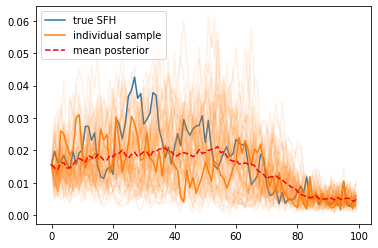

In [17]:
plot(true,label='true SFH')
for i in range(64):
    plot(sample[i,:,0],color='C1',alpha=0.1)
plot(sample[1,:,0],color='C1',alpha=1.,label='individual sample')    
plot(sample.mean(axis=0)[:,0],'--',color='red',label='mean posterior')
legend(loc='upper left')

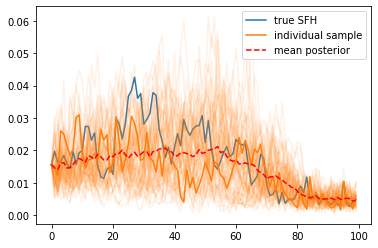

In [18]:
plot(true,label='true SFH')
for i in range(64):
    plot(sample[i,:,0],color='C1',alpha=0.1)
plot(sample[1,:,0],color='C1',alpha=1.,label='individual sample')    
plot(sample.mean(axis=0)[:,0],'--',color='red',label='mean posterior')
legend()

In [153]:
# for i in range(64):
#     figure()
#     plot(true,label='true SFH')
#     plot(sample[i,:,0],color='C1',alpha=1.,label='individual sample')
#     #plot(sample[1,:,0],color='C1',alpha=1.,label='individual sample')    
#     plot(sample.mean(axis=0)[:,0],'--',color='red',label='mean posterior')
#     legend(loc='upper left')
#     ylim(0,1)
#     savefig('sample_%d.png'%i)

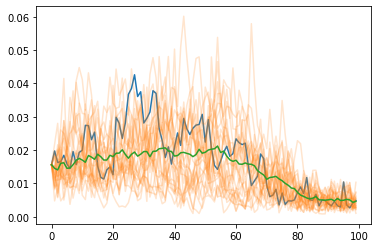

In [20]:
plot(true)
for i in range(25):
    plot(sample[i,:,0],color='C1',alpha=0.2)
plot(sample.mean(axis=0)[:,0],color='C2')

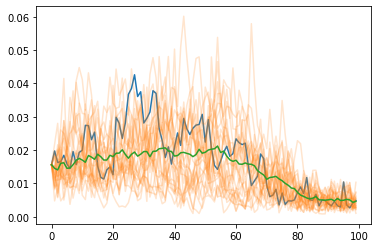

In [21]:
plot(true)
for i in range(25):
    plot(sample[i,:,0],color='C1',alpha=0.2)
plot(sample.mean(axis=0)[:,0],color='C2')

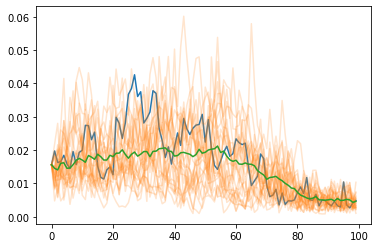

In [22]:
plot(true)
for i in range(25):
    plot(sample[i,:,0],color='C1',alpha=0.2)
plot(sample.mean(axis=0)[:,0],color='C2')

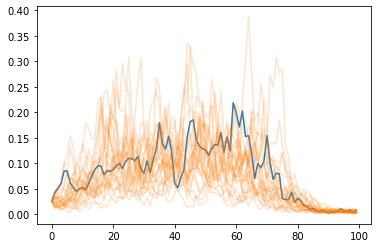

In [63]:
plot(true)
for i in range(25):
    plot(sample[i,:,0],color='C1',alpha=0.2)

## Testing the autoregressiveness of the model

In [76]:
arr = np.zeros(100).reshape([1,100,1])
arr[0,1,0] = 100.

In [77]:
n = pixel_cnn(arr).mean()

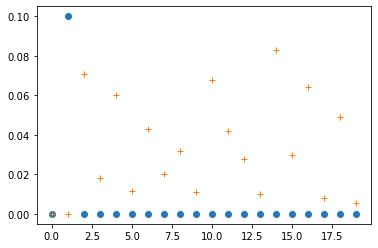

In [78]:
plot(arr[0,:20,0]/1000,'o')
plot(n[0][:20]-0.5,'+')

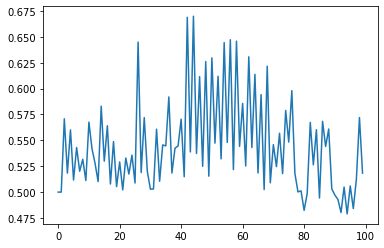

In [80]:
plot(pixel_cnn(arr).mean()[0,:])

In [126]:
layer = keras.layers.Conv1D(
            filters=16,
            kernel_size=3,
            dilation_rate=1,
            padding='causal',
            activation='relu'
        )

layer3=  keras.layers.Lambda(
            lambda x: tf.pad(x, paddings=tf.constant([[0, 0], [1, 0], [0, 0]]))
        )

layer2 = keras.layers.Lambda(
            lambda x: x[:, :-1, :]
        )

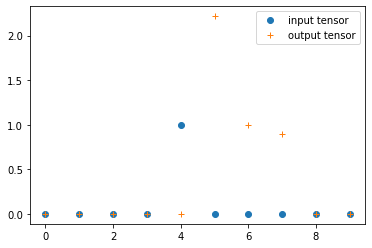

In [127]:

plot(arr[0,:,0][:10],'o', label='input tensor')
plot(layer(layer2(layer3(arr)))[0,:].numpy().sum(axis=-1)[:10], '+', label='output tensor')
legend()